In [127]:
# Helpers
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from tokenizer import create_bag_of_words

# DB
from django.db.models import Case, IntegerField, Value
from spkit import bkt, pfa

In [2]:
folder = "data/ufrj/"
with open("%s/ufrj_dataset_2020_02_17.pkl" % folder, "rb") as pklfile:
    data = pickle.load(pklfile)

In [3]:
data["num_attempts"]

50

In [10]:
student_performance = np.zeros((data["num_users"], data["num_quizs"], data["num_attempts"]))
X = np.zeros(student_performance.shape)

train_set = data["train"]
for item in train_set:
    s_idx, q_idx, a_idx, outcome, _ = item
    if outcome == 0:
        student_performance[s_idx, q_idx, a_idx] = 0.1
    else:
        student_performance[s_idx, q_idx, a_idx] = 1
    X[s_idx, q_idx, a_idx] = 1
    
student_performance[np.where(X[:,:] == 0)] = None
original_student_performance = student_performance.copy()

In [5]:
train_set

array([[ 97,  33,   0,   1,   0],
       [ 97,  33,   1,   1,   0],
       [145,  33,   0,   1,   0],
       ...,
       [186,  47,  33,   0,   0],
       [186,  47,  34,   0,   0],
       [186,  47,  35,   0,   0]])

In [7]:
np.where(X == 1)[2].shape[0]/np.prod(X.shape)*100

1.1619909502262442

In [8]:
%%time
X, student_knowledge, q_matrix = feedback_driven_tensor_factorization(
    student_performance, n_concepts=12, init=3, max_iter=100, mu=10)

NameError: name 'feedback_driven_tensor_factorization' is not defined

In [87]:
%%time
student_performance = original_student_performance.copy()
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
    student_performance, n_concepts=30, init=3, max_iter=100, mu=3)
best_error

Run: 0
Run: 1
Run: 2
CPU times: user 28.6 s, sys: 936 ms, total: 29.5 s
Wall time: 14.8 s


403.60660573646373

In [117]:
bspp_binary = best_student_performance_pred.copy()
bspp_binary[bspp_binary > 0.96] = 1
bspp_binary[bspp_binary < 0.96] = 0

y = student_performance[np.where(X == 1)]
y[y==0.1] = 0
y_pred = best_student_performance_pred[np.where(X == 1)]
y_pred_binary = bspp_binary[np.where(X == 1)]

# best_student_performance_pred[best_student_performance_pred > 0.5] = 1
# best_student_performance_pred[best_student_performance_pred < 0.5] = 0

acc = 100*(np.logical_not(np.logical_xor(
    y, y_pred_binary)).sum())/len(y)
rmse = np.sqrt(np.power((y-y_pred), 2)).mean()

print("Accuracy: %.2f%%" % acc)
print("RMSE: %.2f" % rmse)

Accuracy: 67.81%
RMSE: 0.57


In [118]:
y

array([0., 0., 0., ..., 0., 0., 0.])

In [119]:
y_pred_binary

array([0., 0., 0., ..., 0., 0., 0.])

In [120]:
y_pred

array([0.13830483, 0.23520094, 0.30440606, ..., 0.7705305 , 0.78263196,
       0.79235208])

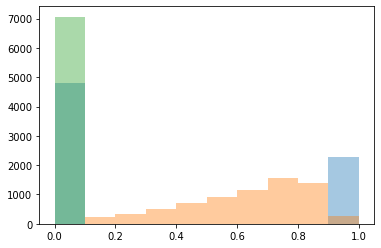

In [121]:
sns.distplot(y, kde=False, bins=np.arange(0, 1.1, 0.1))
sns.distplot(y_pred, kde=False, bins=np.arange(0, 1.1, 0.1))
# sns.distplot(y_pred, kde=False)
sns.distplot(y_pred_binary, kde=False, bins=np.arange(0, 1.1, 0.1))
plt.show()

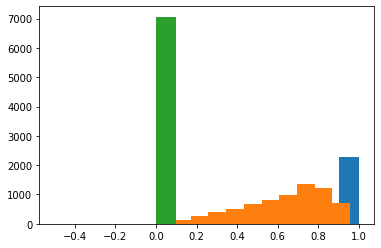

In [123]:
plt.hist(y)
plt.hist(y_pred)
plt.hist(y_pred_binary)
# plt.hist(y)
plt.show()

Youden's optimum threshold: 0.96


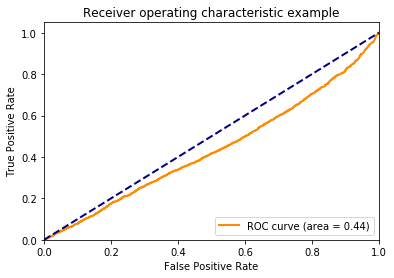

In [102]:
# AUC
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
auc_score = auc(fpr, tpr)
# auc_avg = score['AUC'].mean()
# auc_std = score['AUC'].std()
# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)
# print("AUC de treino: %.2f" % auc_score)
# print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))
estimated_outcome = np.where(np.asarray(y_pred) > J_opt_thresholds, 1, 0)
# adjusted_acc = (estimated_outcome == np.asarray(outcome)).sum()/score['n questions'].sum()
# print("Adjusted Acc: %.2f" % adjusted_acc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [62]:
def feedback_driven_tensor_factorization(student_performance, n_concepts=2, mu=0.1, init=3, max_iter=100):
    """ Student performance: 0 if incorrect, 1 if correct or None if not observed """
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    # Construct tensor X denoting when a student has or has not chosen to work on a problem
    X = np.ones(student_performance.shape)
    X[np.where(np.isnan(student_performance))] = 0
    # Complete student knowledge tensor with zero where is NaN
    student_performance[np.where(np.isnan(student_performance))] = 0
    
    # Create student knowledge tensor
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

#     error_run = []
#     error_total_run = []
#     student_performance_pred_run = []
    best_error = 9999
    lambda1 = 0.0001
    
    # Several starts
    for run in range(init):
        print("Run: %d" % run)
#         error = []
        student_performance_pred_list = []

#         for attempt in range(n_attempts):
#             student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)
        q_matrix = np.random.rand(n_concepts, n_questions)
         # Impose non-negativity constraint
        q_matrix[q_matrix <= 0] = 0.01
        # Normalize rows to sum one
        row_sums = q_matrix.sum(axis=0, keepdims=True)
        if not (np.any(q_matrix.sum(axis=0))):
            raise RuntimeError("Q Matrix with empty row")
        q_matrix = q_matrix / row_sums

        student_performance_pred = np.zeros(student_performance.shape)
        for i in range(max_iter):
            # Phase 2: learning
            # Update T: T = 2*(T_{t-1}) + 2*((1-T_{t-1})/(1+exp(-mu*X_{t}*Q'))) - 1
            # For T0 user T-1 as 0
            student_knowledge[:, :, 0] = (2/(1+np.exp(-mu*np.dot(X[:,:,0], q_matrix.T)))-1)
#             print(student_knowledge[0,:,0])
#             break
#         break
            for attempt in range(1, n_attempts):
                student_knowledge[:, :, attempt] = (2*student_knowledge[:, :, attempt-1]) + \
                2*(1-student_knowledge[:, :, attempt-1])/(1+np.exp(-mu*np.dot(X[:,:,attempt], q_matrix.T))) - 1
#                 print(student_knowledge[0,:,attempt])
                
            
            # Phase 1: prediction
            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
                
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
#             try:
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed+lambda1)
#             except np.linalg.LinAlgError:
#                 return student_knowledge, X, q_matrix, student_knowledge_transposed_inv, TY
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            if not (np.all(row_sums)):
                raise RuntimeError("Q Matrix with empty row")
#                 print("Q Matrix with empty row")
#                 return q_matrix
            q_matrix = q_matrix / row_sums
            
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error = np.sqrt(np.sum(np.power(diff, 2)))
#             error.append(np.sqrt(np.sum(np.power(diff, 2))))
            if error < best_error:
                best_student_performance_pred = student_performance_pred.copy()
                best_student_knowledge = student_knowledge.copy()
                best_q_matrix = q_matrix.copy()
                best_error = error
            
#             student_performance_pred_iter = student_performance_pred.copy()
#             student_performance_pred_list.append(student_performance_pred_iter)
#         student_performance_pred_run.append(student_performance_pred_list)
#         error_run.append(error)
#         error_total_run.append(error[-1])
                
#     return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run
    if best_error == 9999:
        raise RuntimeError("Could not converge")
    return best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error
#     return (np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run, 
#             best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error)

In [125]:
train_set = data["train"]
train_set_bkt = []
for item in train_set:
    train_set_bkt.append([outcome, s_idx, q_idx])

In [128]:
%%time
# Instantiate model
model_bkt = bkt.BKT()
model_pfa = pfa.PFA()

CPU times: user 37 µs, sys: 1 µs, total: 38 µs
Wall time: 44.1 µs


In [ ]:
model_bkt.fit(train_set_bkt, q_matrix)
model_pfa.fit(train_set_bkt, q_matrix)